EE 298 Project 2

Bartolo, Bisnar, Capistrano

# **Shoe Collab GAN**

Automatically generate Shoe Collaboration Designs for **Super Mario x Nike**

## Table of Contents


1.   Connect to Google Drive
2.   Load and Preprocess Data
3.   Build the Cyle GAN with Patch Discriminator
4.   Train the Network
5.   Display Output of Shoe Collab GAN

###Connect to Google Drive

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import os
import numpy as np
from PIL import Image, ImageOps
import cv2

import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
# Connect to google drive with authentication
from google.colab import drive
drive.mount('/content/gdrive')
PATH_OF_DATA = '/content/gdrive/"My Drive"/shoe2collab'
root_path = '/content/gdrive/My Drive/shoe2collab/'

# List all folders
!ls {PATH_OF_DATA}

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
'Luigi Results'   trainA_2   trainC_1   trainC_3   TrainE
 trainA		  trainB     trainC_2   trainD	   trainF


###Load and Preprocess Data

In [0]:
#Storing the names of shoes and characters in a list

dir = '/content/gdrive/My Drive/shoe2collab'
train_character_dir = dir + '/trainA_2/' #Folder Containing Character Images (Mario/Luigi/Princess Peach)
train_shoe_dir = dir + '/trainB/' #Folder Containing Nike Shoe Images

character_addr = [train_character_dir+i for i in os.listdir(train_character_dir)]
shoe_addr = [train_shoe_dir+i for i in os.listdir(train_shoe_dir)]

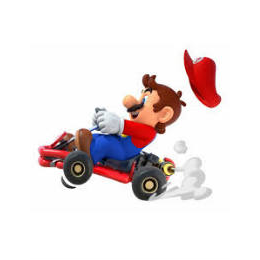

In [0]:
ImageOps.expand(Image.open(character_addr[0]),border=(30,0),fill='white')

In [0]:
#Preprocessing data so that every value in the image array is between -1 and 1. 

def create_train_sets(character_addr, shoe_addr):
    
    X_train, Y_train = np.zeros((100, 3, 128, 128), dtype=np.float32), np.zeros((1024, 3, 128, 128), dtype=np.float32)
    
    for i in range(len(character_addr)):
        temp_np = np.asarray(ImageOps.expand(Image.open(character_addr[i]),border=(30,0),fill='white').resize((128, 128), Image.ANTIALIAS))  #resizing the image to 128x128
        X_train[i] = temp_np.transpose(2, 0, 1)
        X_train[i] /= 255
        X_train[i] = X_train[i] * 2 -  1
        print('character_addr '+ str(i) + ' of ' + str(len(character_addr)))
        
    for i in range(len(shoe_addr)):
        temp_np = np.asarray(ImageOps.expand(Image.open(shoe_addr[i]),border=(30,0),fill='white').resize((128, 128), Image.ANTIALIAS))
        Y_train[i] = temp_np.transpose(2, 0, 1)
        Y_train[i] /= 255
        Y_train[i] = Y_train[i] * 2 -  1
        print('shoe_addr '+ str(i) + ' of ' + str(len(shoe_addr)))
    
    return X_train, Y_train

In [0]:
X_train, Y_train = create_train_sets(character_addr, shoe_addr)  

In [0]:
X_tensor = torch.from_numpy(X_train)                #Creating Tensors which will later be wrapped into variables
Y_tensor = torch.from_numpy(Y_train)

###Build the Cyle GAN with Patch Discriminator

---
In this project, we use **Cycle GAN with Patch Discriminator**.

*   For each Generator, we use the combination of two Discriminators (Patch and Non-Patch) 
*   Patch Discriminator - 70 × 70 PatchGANs, which aim to classify whether 70 × 70 overlapping image patches are real or fake
*   Non-Patch Discriminator - Aims to classify whether the entire 128 × 128 image is real or fake (i.e. a regular GAN discriminator)
Scores from both discriminator are given weights (0.8 for Patch, 0.2 for Non-Patch) and are added in order to arrive with a single score



In [0]:
class discriminator_nonpatch(nn.Module):
    def __init__(self):
        super(discriminator_nonpatch, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=6, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv1(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return Fn.sigmoid(x)

In [0]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv1(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return Fn.sigmoid(x)

In [0]:
class generator(nn.Module):         #padding concerns: reflection? What exactly is the concept behind convTranspose?
    
    def __init__(self):
        super(generator, self).__init__()
        
        #c7s1-32
        self.r1 = nn.ReflectionPad2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        #d64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        #d128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        #R128
        self.r4 = nn.ReflectionPad2d(1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.r5 = nn.ReflectionPad2d(1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)
        
        #R128
        self.r6 = nn.ReflectionPad2d(1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.r7 = nn.ReflectionPad2d(1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn7 = nn.BatchNorm2d(128)
        
        #R128
        self.r8 = nn.ReflectionPad2d(1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.r9 = nn.ReflectionPad2d(1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn9 = nn.BatchNorm2d(128)
        
        #R128
        self.r10 = nn.ReflectionPad2d(1)
        self.conv10 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn10 = nn.BatchNorm2d(128)
        
        self.r11 = nn.ReflectionPad2d(1)
        self.conv11 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn11 = nn.BatchNorm2d(128)
        
        #R128
        self.r12 = nn.ReflectionPad2d(1)
        self.conv12 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn12 = nn.BatchNorm2d(128)
        
        self.r13 = nn.ReflectionPad2d(1)
        self.conv13 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn13 = nn.BatchNorm2d(128)
        
        #R128
        self.r14 = nn.ReflectionPad2d(1)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn14 = nn.BatchNorm2d(128)
        
        self.r15 = nn.ReflectionPad2d(1)
        self.conv15 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn15 = nn.BatchNorm2d(128)
        
        #u64
        self.uconv16 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn16 = nn.BatchNorm2d(64)
        
        #u32
        self.uconv17 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn17 = nn.BatchNorm2d(32)
        
        #c7s1-3
        self.r18 = nn.ReflectionPad2d(3)
        self.conv18 = nn.Conv2d(32, 3, kernel_size=7, stride=1)
        self.bn18 = nn.BatchNorm2d(3)
        
    def forward(self, input):
        
        #c7s1-32
        x = Fn.leaky_relu(self.bn1(self.conv1(self.r1(input))), negative_slope=0.2)
        
        #d64
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        
        #d128
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        
        #R128
        x1 = Fn.leaky_relu(self.bn4(self.conv4(self.r4(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn5(self.conv5(self.r5(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn6(self.conv6(self.r6(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn7(self.conv7(self.r7(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn8(self.conv8(self.r8(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn9(self.conv9(self.r9(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn10(self.conv10(self.r10(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn11(self.conv11(self.r11(x1))), negative_slope=0.2)
        
        x = x + x1
       
        #R128
        x1 = Fn.leaky_relu(self.bn12(self.conv12(self.r12(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn13(self.conv13(self.r13(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn14(self.conv14(self.r14(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn15(self.conv15(self.r15(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #u64
        x = Fn.leaky_relu(self.bn16(self.uconv16(x)), negative_slope=0.2)
        
        #u32
        x = Fn.leaky_relu(self.bn17(self.uconv17(x)), negative_slope=0.2)
        
        #c7s1-3
        x = Fn.leaky_relu(self.bn18(self.conv18(self.r18(x))), negative_slope=0.2)
        
        return Fn.tanh(x)

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)

The function below is used to divide a 128x128 image into multiple 70x70 images.

These images are then passed through our discriminator and then the scores are averaged.

In [0]:
def pass_through_discriminator(discriminator, image):
    score, k = 0, Variable(torch.zeros(1)).type(dtype)
    xp, yp = 0, 0
    x, y = 70, 70
    offset = 25
    
    while x < 128:
        while y < 128:
            k += 1
            score += discriminator(image[:, :, xp:x, yp:y])
            yp += offset
            y += offset
            
        xp += offset
        x += offset
        
    return score / k

In [0]:
dtype = torch.FloatTensor

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    
G = generator().type(dtype)
F = generator().type(dtype)

Dg = discriminator().type(dtype)
Df = discriminator().type(dtype)
Dgnp = discriminator_nonpatch().type(dtype)
Dfnp = discriminator_nonpatch().type(dtype)

G.apply(weights_init)
F.apply(weights_init)
Dg.apply(weights_init)
Df.apply(weights_init)

G_optim = optim.Adam(G.parameters(), lr=0.0002)    #Learning rates directly borrowed from the paper
F_optim = optim.Adam(F.parameters(), lr=0.0002)

Dg_optim = optim.Adam(Dg.parameters(), lr=0.0001)
Df_optim = optim.Adam(Df.parameters(), lr=0.0001)

# learning rate decay
G_scheduler = optim.lr_scheduler.StepLR(G_optim, step_size=100, gamma=0.1)
F_scheduler = optim.lr_scheduler.StepLR(F_optim, step_size=100, gamma=0.1)
Dg_scheduler = optim.lr_scheduler.StepLR(Dg_optim, step_size=100, gamma=0.1)
Df_scheduler = optim.lr_scheduler.StepLR(Df_optim, step_size=100, gamma=0.1)


###Train the Network

---

In [0]:
# Training Proper

epochs = 60
batch_size = 3

G.train()
F.train()
Dg.train()
Df.train()

k = 0

for epoch in range(epochs):
    print('Epoch number: '+str(epoch))
    
    G_scheduler.step()
    F_scheduler.step()
    Dg_scheduler.step()
    Df_scheduler.step()
    
    for batch in range(X_tensor.size(0) // batch_size):
        if batch % 100 == 0:
            #print '**Batch number: {0}**'.format(batch)
            print('Batch number: '+str(batch))
        
        character_real = X_tensor[batch * batch_size: (batch + 1) * batch_size]
        if k!= 1023:
            shoe_real = Y_tensor[k % 1024: (k + 1) % 1024]       
        else:
            shoe_real = Y_tensor[1023]
            shoe_real = shoe_real[np.newaxis, ...]
        k += 1
        
        character_real = Variable(character_real).type(dtype)
        shoe_real = Variable(shoe_real).type(dtype)
        
        #Train GAN G
        
        #Train Dg
        shoe_fake = G(character_real)
        
        scores_real = pass_through_discriminator(Dg, shoe_real)
        scores_real_np = Dgnp(shoe_real)
        scores_fake = pass_through_discriminator(Dg, shoe_fake)
        scores_fake_np = Dgnp(shoe_fake)
        
        label_fake = Variable(torch.zeros(batch_size)).type(dtype)
        label_real = Variable(torch.ones(batch_size)).type(dtype)
        
        scores_real = (0.8 * scores_real + 0.2 * scores_real_np) 
        scores_fake = (0.8 * scores_fake + 0.2 * scores_fake_np) 
        
        loss1 = torch.mean((scores_real - label_real)**2)
        loss2 = torch.mean((scores_fake - label_fake)**2)
        
        Dg_optim.zero_grad()
        
        loss_dg = (loss1 + loss2)
        if batch % 100 == 0:
            #print 'Discriminator G loss: {0}'.format(loss_dg.data[0])
            print('Discriminator G loss: '+str(loss_dg.data))  
        loss_dg.backward()
        
        Dg_optim.step()

        #Train G
        shoe_fake = G(character_real)
        
        scores_fake = pass_through_discriminator(Dg, shoe_fake)
        loss_g = torch.mean((scores_fake - label_real)**2) + 10 * torch.mean(torch.abs(G(F(shoe_real)) - shoe_real))
        if batch % 100 == 0:
            #print 'Generator G loss: {0}'.format(loss_g.data[0])
            print('Generator G loss: '+str(loss_g.data))
        
        G_optim.zero_grad()
        loss_g.backward()
        G_optim.step()
        
        #Train GAN F
        
        character_fake = F(shoe_real)
        
        scores_real = pass_through_discriminator(Df, character_real)
        scores_real_np = Dfnp(character_real)
        scores_fake = pass_through_discriminator(Df, character_fake)
        scores_fake_np = Dfnp(character_fake)
        
        scores_real = (0.8 * scores_real + 0.2 * scores_real_np)
        scores_fake = (0.8 * scores_fake + 0.2 * scores_fake_np)
        
        loss1 = torch.mean((scores_real - label_real)**2)
        loss2 = torch.mean((scores_fake - label_fake)**2)
        
        Df_optim.zero_grad()
        
        loss_df = (loss1 + loss2)
        if batch % 100 == 0:
            #print 'Discriminator F loss: {0}'.format(loss_df.data[0])
            print('Discriminator F loss: '+str(loss_df.data))
        loss_df.backward()
        
        Df_optim.step()
        
        #Train F
        
        character_fake = F(shoe_real)
        
        scores_fake = pass_through_discriminator(Df, character_fake)
        loss_f = torch.mean((scores_fake - label_real)**2) + 10 * torch.mean(torch.abs(F(G(character_real)) - character_real))
        if batch % 100 == 0:
            #print 'Generator F loss: {0}'.format(loss_f.data[0])
            print('Generator F loss: '+str(loss_f.data))
        
        F_optim.zero_grad()
        loss_f.backward()
        F_optim.step()

Epoch number: 0
Batch number: 0
Discriminator G loss: tensor(0.2711, device='cuda:0')
Generator G loss: tensor(2.7238, device='cuda:0')
Discriminator F loss: tensor(0.0212, device='cuda:0')
Generator F loss: tensor(2.3018, device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch number: 1
Batch number: 0
Discriminator G loss: tensor(0.5175, device='cuda:0')
Generator G loss: tensor(3.0010, device='cuda:0')
Discriminator F loss: tensor(0.0184, device='cuda:0')
Generator F loss: tensor(2.3300, device='cuda:0')
Epoch number: 2
Batch number: 0
Discriminator G loss: tensor(0.2108, device='cuda:0')
Generator G loss: tensor(2.5776, device='cuda:0')
Discriminator F loss: tensor(0.0192, device='cuda:0')
Generator F loss: tensor(2.3142, device='cuda:0')
Epoch number: 3
Batch number: 0
Discriminator G loss: tensor(0.1583, device='cuda:0')
Generator G loss: tensor(1.9773, device='cuda:0')
Discriminator F loss: tensor(0.0198, device='cuda:0')
Generator F loss: tensor(2.3100, device='cuda:0')
Epoch number: 4
Batch number: 0
Discriminator G loss: tensor(0.1577, device='cuda:0')
Generator G loss: tensor(1.6402, device='cuda:0')
Discriminator F loss: tensor(0.0186, device='cuda:0')
Generator F loss: tensor(2.3055, device='cuda:0')
Epoch number: 5
Batch number: 0
Discrimi

In [0]:
def shoecollab(shoe_addr):
    #img = Image.open(shoe_addr)
    img = ImageOps.expand(Image.open(shoe_addr),border=(30,0),fill='white')
    img_np = np.zeros((1, 3, 128, 128), dtype=np.float32)
    temp_np = np.asarray(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(temp_np)
    
    img_np[0] = temp_np.transpose(2, 0, 1)
    
    img_np /= 255
    img_np = img_np * 2 - 1
    img_tensor = torch.from_numpy(img_np)
    img_var = Variable(img_tensor).type(dtype)
    
    collab_var = F(img_var)
    collab = collab_var.data.cpu().numpy()
    collab = collab[0].transpose(1, 2, 0)
    collab = (collab + 1)/2
    plt.figure()
    plt.imshow(collab)

###Display Output of Shoe Collab GAN

---

Shown below are the input (shoe) images and the corresponding output (stylized shoe).

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


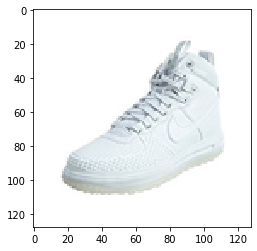

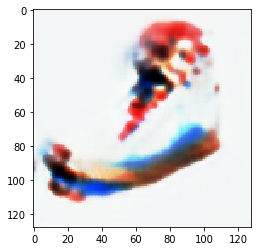

In [0]:
shoecollab(shoe_addr[30])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


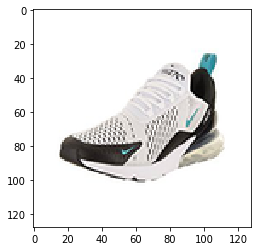

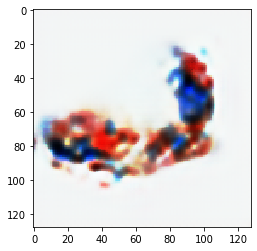

In [0]:
shoecollab(shoe_addr[450])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


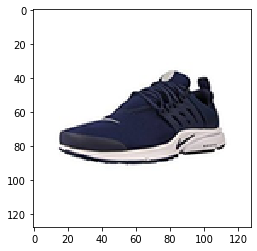

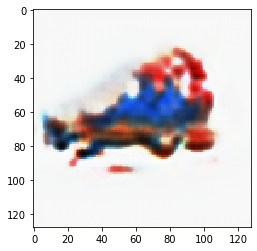

In [0]:
shoecollab(shoe_addr[560])